## Interference-Aware Scheduling to Avoid SLO Violations

This notebook builds our SLO-Aware, Interference-Conscious scheduling pipeline.  
We will:

1. **Ingest** raw performance (wrk2) and hardware-counter (PCM) data.  
2. **Profile** each interference scenario by aggregating PCM metrics into summary features.  
3. **Join** these features with the observed P99-latencies to form our ML dataset.  
4. **Preprocess** the features (scaling, polynomial expansion) and construct a reusable pipeline.  
5. **Train & Evaluate** multiple regression models (linear+poly, Random Forest, kNN) using leave-one-out CV.  
6. **Select** the best model to compute our `RiskScore = predicted_P99 / SLO_threshold`, which will guide scheduling decisions.


In [1]:
import os
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
import base64
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.lines import Line2D  # For custom legend

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import xgboost as xgb


### 1.1 View Data

In [2]:
local_results_folder = Path("./Memento_V01")
file_patterns = {
    #"perf": "*perf*.csv",
    "pcm_system": "*pcm_system*.csv",
    "pcm_cores": "*pcm_core*.csv",
    #"container_detail": "*container_metrics_detail*.csv",
    #"container_agg": "*container_metrics_agg*.csv",
    "nginx": "*nginx*.csv",
}

#### Example of each data file

In [3]:
# Loop through each category and find the first matching CSV file.
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        # Optionally, re-save the file with comma as separator and without the index.
        # If you prefer to keep the original file intact, you can comment out the next line.
        df.to_csv(selected_file, sep=",", index=False)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        display(df.head(5))  # Use display() if you're in a Jupyter Notebook, otherwise use print(df.head(5))
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: pcm_system - File: pcm_system_1replicas_scenario12_100rps.csv ===


,System - Date,System - Time,System - IPC,System - L3MISS,System - L2MISS,System - READ,System - WRITE,System - PhysIPC,System - PhysIPC%,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,System Pack C-States - C0res%,System Pack C-States - C6res%
0,2025-07-01,03:17:37.190,1.32,0.07,0.45,1.25,0.16,2.64,52.74,0.68,75.08,0.0,97.85,0.07
1,2025-07-01,03:17:42.191,1.31,0.06,0.45,1.06,0.13,2.62,52.41,0.69,77.08,0.0,99.04,0.02
2,2025-07-01,03:17:47.191,1.32,0.07,0.47,1.10,0.14,2.65,52.95,0.71,76.12,0.0,98.92,0.01
3,2025-07-01,03:17:52.192,1.35,0.05,0.43,0.99,0.12,2.69,53.83,0.70,76.70,0.0,99.23,0.02
4,2025-07-01,03:17:57.192,1.30,0.08,0.50,1.13,0.14,2.60,52.03,0.71,76.55,0.0,98.74,0.03




=== Category: pcm_cores - File: pcm_core_1replicas_scenario31_3000rps.csv ===


,System - Date,System - Time,System Core C-States - C0res%,System Core C-States - C1res%,System Core C-States - C6res%,SKT0 Core C-State - C0res%,SKT0 Core C-State - C1res%,SKT0 Core C-State - C6res%,Core0 (Socket 0) - IPC,Core0 (Socket 0) - L3MISS,...,Core6 (Socket 0) - PhysIPC,Core6 (Socket 0) - PhysIPC%,Core7 (Socket 0) - IPC,Core7 (Socket 0) - L3MISS,Core7 (Socket 0) - L2MISS,Core7 (Socket 0) - C0res%,Core7 (Socket 0) - C1res%,Core7 (Socket 0) - C6res%,Core7 (Socket 0) - PhysIPC,Core7 (Socket 0) - PhysIPC%
0,2025-07-01,09:47:02.180,1.13,91.81,0.0,1.13,91.81,0.0,0.76,0.02,...,2.07,41.37,0.72,0.01,0.55,1.54,88.40,0.0,1.44,28.72
1,2025-07-01,09:47:07.181,1.31,98.69,0.0,1.31,98.69,0.0,0.75,0.01,...,2.10,42.07,0.72,0.01,0.64,1.80,98.20,0.0,1.43,28.67
2,2025-07-01,09:47:12.181,1.18,98.82,0.0,1.18,98.82,0.0,0.71,0.02,...,2.09,41.77,0.73,0.02,0.66,1.89,98.11,0.0,1.45,29.06
3,2025-07-01,09:47:17.181,1.33,98.67,0.0,1.33,98.67,0.0,0.85,0.02,...,2.07,41.43,0.73,0.02,0.66,1.91,98.09,0.0,1.47,29.38
4,2025-07-01,09:47:22.181,1.30,98.70,0.0,1.30,98.70,0.0,0.62,0.01,...,2.13,42.56,0.72,0.02,0.70,1.81,98.19,0.0,1.44,28.73




=== Category: nginx - File: nginx_metrics.csv ===


,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_100rps,1,Baseline0,0,100,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0
1,1replicas_scenario1_100rps,1,Baseline1,1,100,100.005295,0.307,0.317,0.0,0.493,0.548,0.598,1.136,0
2,1replicas_scenario2_100rps,1,Baseline2,2,100,100.005002,0.305,0.314,0.0,0.489,0.546,0.600,3.619,0
3,1replicas_scenario11_100rps,1,1_iBench_CPU_pod,11,100,100.005151,0.337,0.314,0.0,0.501,0.562,1.756,3.351,0
4,1replicas_scenario12_100rps,1,2_iBench_CPU_pods,12,100,100.005424,0.331,0.307,0.0,0.476,0.548,1.443,6.777,0


#### Columns in each data file

In [4]:
# Show the list of columns for each category
for category, pattern in file_patterns.items():
    # Construct the search pattern
    search_pattern = os.path.join(local_results_folder, pattern)
    matching_files = glob.glob(search_pattern)
    
    # Check if there is at least one matching file
    if matching_files:
        # Select the first matching file
        selected_file = matching_files[0]
        
        # Read the CSV into a DataFrame
        df = pd.read_csv(selected_file)
        
        print(f"=== Category: {category} - File: {os.path.basename(selected_file)} ===")
        print(df.columns.tolist())
        print("\n")
    else:
        print(f"No file found for the category: {category}\n")

=== Category: pcm_system - File: pcm_system_1replicas_scenario12_100rps.csv ===
['System - Date', 'System - Time', 'System - IPC', 'System - L3MISS', 'System - L2MISS', 'System - READ', 'System - WRITE', 'System - PhysIPC', 'System - PhysIPC%', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'System Pack C-States - C0res%', 'System Pack C-States - C6res%']


=== Category: pcm_cores - File: pcm_core_1replicas_scenario31_3000rps.csv ===
['System - Date', 'System - Time', 'System Core C-States - C0res%', 'System Core C-States - C1res%', 'System Core C-States - C6res%', 'SKT0 Core C-State - C0res%', 'SKT0 Core C-State - C1res%', 'SKT0 Core C-State - C6res%', 'Core0 (Socket 0) - IPC', 'Core0 (Socket 0) - L3MISS', 'Core0 (Socket 0) - L2MISS', 'Core0 (Socket 0) - C0res%', 'Core0 (Socket 0) - C1res%', 'Core0 (Socket 0) - C6res%', 'Core0 (Socket 0) - PhysIPC', 'Core0 (Socket 0) - PhysIPC%', 'Core1 (Socket 0) - IPC', 'Core1 (Socket 0) - L3MISS',

In [5]:
## For PCM Files

# Helper to clean column names
def clean_col(col):
    col = col.replace('System - ', '')
    col = col.replace('System Core C-States - ', 'core_c_')
    col = col.replace('System Pack C-States - ', 'pack_c_')
    col = col.replace(' ', '_').replace('-', '').lower()
    return col

In [6]:
Data_Dir = 'Memento_V01'
Perfomance_File = os.path.join(Data_Dir, 'nginx_metrics.csv')


if os.path.exists(Perfomance_File):
    df_perf = pd.read_csv(Perfomance_File)
    print("Loaded performance metrics:")
    display(df_perf)
    print(df_perf.shape)
else:
    print(f"Performance file not found at {Perfomance_File}. Please verify path.")
    df_perf = pd.DataFrame()

Loaded performance metrics:


,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_100rps,1,Baseline0,0,100,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0
1,1replicas_scenario1_100rps,1,Baseline1,1,100,100.005295,0.307,0.317,0.0,0.493,0.548,0.598,1.136,0
2,1replicas_scenario2_100rps,1,Baseline2,2,100,100.005002,0.305,0.314,0.0,0.489,0.546,0.600,3.619,0
3,1replicas_scenario11_100rps,1,1_iBench_CPU_pod,11,100,100.005151,0.337,0.314,0.0,0.501,0.562,1.756,3.351,0
4,1replicas_scenario12_100rps,1,2_iBench_CPU_pods,12,100,100.005424,0.331,0.307,0.0,0.476,0.548,1.443,6.777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1replicas_scenario24_4000rps,1,4_stress-ng_l3_pods,24,4000,3999.943588,0.702,0.424,0.0,1.677,2.279,3.829,12.463,0
131,1replicas_scenario31_4000rps,1,1_iBench_memBW_pod,31,4000,4000.002956,0.106,0.096,0.0,0.149,0.170,0.257,3.521,0
132,1replicas_scenario32_4000rps,1,2_iBench_memBW_pods,32,4000,4000.003034,0.109,0.098,0.0,0.152,0.175,0.278,4.128,0
133,1replicas_scenario33_4000rps,1,3_iBench_memBW_pods,33,4000,3999.982140,0.134,0.110,0.0,0.211,0.272,0.463,4.508,0


(135, 14)


### 1.3 Combine Data from Different Tests

In [7]:
import os
import pandas as pd

# Folders that I will use for the analysis
folders = ["Memento_V01", "Memento_V02", "Memento_V03", "Memento_V04","Memento_V02_3_MixedScenarios", "Memento_V01_mix_scenarios", "TheGame_V01", "TheGame_V02","TheGame_V02_2", "TheGame_V03", "TheGame_V04", "TheGame_MIX_V01", "TheGame_MIX_V02"]

folders.append("Fight_Club_V01")
folders.append("Fight_Club_V02")
folders.append("Green_Book_V01")

def load_and_average_perf_data(folders, filename="nginx_metrics.csv"):
    all_data = []

    for folder in folders:
        filepath = os.path.join(folder, filename)
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            df["FolderID"] = folder
            df["UniqueID"] = df["Test_ID"].astype(str) + "_" + folder
            all_data.append(df)
        else:
            print(f"Warning: File not found in {folder}")

    if not all_data:
        print("No data loaded.")
        return pd.DataFrame()

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    # Metrics to average
    metrics = [
        "Throughput", "Avg_Latency", "P50_Latency", "P75_Latency",
        "P90_Latency", "P95_Latency", "P99_Latency", "Max_Latency", "Errors"
    ]

    # Columns to group by (everything else except those being averaged)
    fixed_columns = [col for col in combined_df.columns if col not in metrics]

    # Group by UniqueID and compute mean of metrics
    averaged_df = combined_df.groupby("UniqueID", as_index=False).agg({
        **{col: 'first' for col in fixed_columns if col != "UniqueID"},
        **{metric: 'mean' for metric in metrics}
    })

    return averaged_df

In [8]:
df_perf = load_and_average_perf_data(folders)

In [9]:
display(df_perf)

,UniqueID,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,FolderID,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors
0,1replicas_scenario0_1000rps_Fight_Club_V01,1replicas_scenario0_1000rps,1,Baseline0,0,1000,Fight_Club_V01,1000.004331,0.087,0.084,0.0,0.100,0.108,0.141,2.682,0.0
1,1replicas_scenario0_1000rps_Memento_V01,1replicas_scenario0_1000rps,1,Baseline0,0,1000,Memento_V01,1000.002275,0.087,0.084,0.0,0.100,0.108,0.150,3.678,0.0
2,1replicas_scenario0_1000rps_TheGame_V01,1replicas_scenario0_1000rps,1,Baseline0,0,1000,TheGame_V01,1000.003594,0.088,0.085,0.0,0.102,0.111,0.146,3.211,0.0
3,1replicas_scenario0_100rps_Memento_V01,1replicas_scenario0_100rps,1,Baseline0,0,100,Memento_V01,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0.0
4,1replicas_scenario0_100rps_TheGame_V01,1replicas_scenario0_100rps,1,Baseline0,0,100,TheGame_V01,100.005097,0.295,0.310,0.0,0.442,0.539,0.606,2.918,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,4replicas_scenario58_2500rps_TheGame_MIX_V02,4replicas_scenario58_2500rps,4,1_L3_3_MemBW,58,2500,TheGame_MIX_V02,2500.004305,0.217,0.165,0.0,0.413,0.522,0.723,5.128,0.0
1905,4replicas_scenario58_3000rps_TheGame_MIX_V02,4replicas_scenario58_3000rps,4,1_L3_3_MemBW,58,3000,TheGame_MIX_V02,3000.000833,0.278,0.247,0.0,0.430,0.506,0.776,10.012,0.0
1906,4replicas_scenario58_3500rps_TheGame_MIX_V02,4replicas_scenario58_3500rps,4,1_L3_3_MemBW,58,3500,TheGame_MIX_V02,3500.001452,0.201,0.162,0.0,0.356,0.427,0.635,7.087,0.0
1907,4replicas_scenario58_4000rps_TheGame_MIX_V02,4replicas_scenario58_4000rps,4,1_L3_3_MemBW,58,4000,TheGame_MIX_V02,4000.018785,0.232,0.190,0.0,0.388,0.486,0.877,11.036,0.0


In [10]:
# print unique values of replicas
def print_unique_replicas(df):
    if 'Replicas' in df.columns:
        unique_replicas = df['Replicas'].unique()
        print("Unique Replicas:", unique_replicas)
        unique_interference_ids = df['Interference_ID'].unique()
        print("Unique Interference IDs:", unique_interference_ids)
    else:
        print("No 'Replica' column found in the DataFrame.")    
print_unique_replicas(df_perf)

Unique Replicas: [1 2 3 4]
Unique Interference IDs: [ 0 11 12 13 14  1 21 22 23 24  2 31 32 33 34 51 52 53 54 55 56 57 58 59
 60 61 62 63 64]


In [11]:
# Define interference types and their ranges
interference_types = {
    'CPU': (10, 14),
    'L3': (20, 24),
    'Membw': (30, 34),
    'Baseline': (0, 2)
}

# Function to categorize interference
def categorize_interference(row):
    if row['Interference_ID'] <= 2:
        return 'Baseline'
    elif 10 <= row['Interference_ID'] <= 14:
        return 'CPU'
    elif 20 <= row['Interference_ID'] <= 24:
        return 'L3'
    elif 30 <= row['Interference_ID'] <= 34:
        return 'Membw'
    elif 50 <= row['Interference_ID'] <= 58:
        return 'Mix'
    else:
        return 'Other'

# Add interference category column
df_perf['Interference_Category'] = df_perf.apply(categorize_interference, axis=1)

In [12]:
def label_scenarios(df):
    def generate_label(row):
        iid = row['Interference_ID']
        if iid in [0, 1, 2, 3, 4]:
            return f"B{iid}"
        elif 10 <= iid <= 14:
            return f"CPU{iid - 10}"
        elif 20 <= iid <= 24:
            return f"L3_{iid - 20}"
        elif 30 <= iid <= 34:
            return f"MEM{iid - 30}"
        elif 50 <= iid <= 58:
            return f"MIX{iid - 50}"
        
        # Add the same code for IDs from 200 to 234
        if iid in [200, 201, 202, 203, 204]:
            return f"B{iid-200}"
        elif 210 <= iid <= 214:   
            return f"CPU{iid - 210}"
        elif 220 <= iid <= 224:
            return f"L3_{iid - 220}"
        elif 230 <= iid <= 234:
            return f"MEM{iid - 230}"
        else:
            return f"ID{iid}"

    df = df.copy()
    df['Scenario_Label'] = df.apply(generate_label, axis=1)
    return df

## 2. Perfomance

### 2.0 Show Results 

### 2.1 Normalized Perfomance
**Formula:**  
$$
\mathrm{NormalizedPerf} \;=\; \frac{\mathrm{Perf}_{\text{baseline}}}{\mathrm{Perf}_{\text{interference}}}
$$

*(Perf = p90 latency, so lower is better)*

**Usage**  
- Compares “what fraction of baseline performance remains” under interference.  
- Ideal for benchmarking across heterogeneous workloads or hardware.  
- Plots easily on a uniform [0–1] scale where 1.0 means no impact.

**Why We Need It**  
- Provides a **relative**, unit‐free measure of interference impact.  
- Allows apples-to-apples comparison even when absolute latencies differ.  
- Highlights which co-locations preserve most of their performance.

In [13]:
def compute_normalized_performance(df_perf, metric='P99_Latency'):
    baseline_names = ["Baseline0", "Baseline1", "Baseline2"]

    # Filter baseline entries
    df_baseline = df_perf[df_perf["Interference_Name"].isin(baseline_names)]

    # Compute baseline means for each (Replicas, RPS) pair
    df_baseline_mean = df_baseline.groupby(["Replicas", "Given_RPS"]).agg({
        "Throughput": "mean",
        "Avg_Latency": "mean",
        "P50_Latency": "mean",
        "P75_Latency": "mean",
        "P90_Latency": "mean",
        "P95_Latency": "mean",
        "P99_Latency": "mean",
        "Max_Latency": "mean"
    }).reset_index()

    # Create lookup dictionary for (Replicas, Given_RPS) -> baseline P99
    baseline_metric_lookup = df_baseline_mean.set_index(["Replicas", "Given_RPS"])[metric].to_dict()

    def compute_norm_perf(row):
        key = (row["Replicas"], row["Given_RPS"])
        baseline_metric = baseline_metric_lookup.get(key, None)

        if row["Interference_Name"] in baseline_names:
            return 1.0
        elif baseline_metric is not None and row[metric] != 0:
            return baseline_metric / row[metric]
        else:
            return float('nan')

    df_perf = df_perf.copy()
    df_perf["norm_perf"] = df_perf.apply(compute_norm_perf, axis=1)
    return df_perf

# Example usage:
df_perf = compute_normalized_performance(df_perf)


In [14]:
# Print the head of the dataframe 
#print(df_perf.head()

### 2.2 QoS Degradation
**Formula:**  
$$
\mathrm{QoS\_Degrad\%} \;=\; \frac{\mathrm{Perf}_{\text{with-intf}} \;-\; \mathrm{Perf}_{\text{alone}}}{\mathrm{Perf}_{\text{alone}}} \times 100\%
$$
**Usage**  
- Reports the **absolute** (or percentage) change in your QoS metric (e.g. +20 ms p90).  
- Ideal for capacity-planning (“each co-tenant adds this many milliseconds of tail latency”).

**Why We Need It**  
- Conveys the **magnitude** of slowdown in concrete units.  
- Helps operators budget additional latency and plan SLAs.

### 2.3 SLO Violation

**Formula:**  
$$
\mathrm{SLO\_ViolRate} \;=\; \frac{\bigl|\{\text{requests with latency} > \text{SLO\_threshold}\}\bigr|}{\text{total requests}}
$$

**Usage**  
- Measures the **fraction** (or count) of requests that breach your latency SLO.  
- Reported as a % or per-million rate, often over time or per scenario.

**Why We Need It**  
- Directly ties interference to user-visible failures or timeouts.  
- Captures threshold effects where small latency shifts cause large violation spikes.

### 2.4 Interference Sensitivity

**Formula**  
$$
\mathrm{Sensitivity} \;=\; \frac{\mathrm{Perf}_{\text{alone}} - \mathrm{Perf}_{\text{with-intf}}}{\mathrm{Perf}_{\text{alone}}}
\;=\; 1 \;-\; \mathrm{NormalizedPerf}
$$

**Usage**  
- Ranks workloads by **percent degradation** under interference.  
- Drives scheduler heuristics: e.g. “never co-locate two pods with > 30 % sensitivity.”  
- Plots as a single “pain score” per interference scenario.

**Why We Need It**  
- A concise score of how badly each service suffers.  
- Simplifies placement decisions by collapsing multiple metrics into one.  
- Highlights which pods need strongest isolation or resource guarantees.

## Plots of Normalized Performance

In [15]:
df_labeled = label_scenarios(df_perf)

In [16]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_interference_effect(df_labeled: pd.DataFrame,
                             interference: str,
                             mid_rps: int | None = None,
                             rps_pair: tuple[int, int] | None = None,
                             rps_triplet: tuple[int, int, int] | None = None,
                             fixed_replicas_for_rps: int | None = 2):
    # ---- helpers ----
    def _norm_token(s: str) -> str:
        s = s.lower()
        s = s.replace('-', '').replace('_', '')
        return s

    token = _norm_token(interference)
    # Match Interference_Category robustly (CPU, CPU-bound, etc.)
    cat_mask = df_labeled['Interference_Category'].str.lower().str.replace('-', '').str.contains(token, na=False)
    base_mask = df_labeled['Interference_Category'].str.lower().str.contains('baseline', na=False)
    df_cat = df_labeled[cat_mask].copy()
    df_base = df_labeled[base_mask].copy()
    df_use = pd.concat([df_base, df_cat], ignore_index=True)

    if df_use.empty:
        raise ValueError(f"No rows found for interference '{interference}'")

    # Establish scenario order: Baselines first (B0,B1,...) then selected type (CPU1..)
    def nat_key(lbl: str):
        # group order: Baseline first
        grp = 0 if lbl.upper().startswith('B') else 1
        m = re.search(r'(\d+)$', str(lbl))
        num = int(m.group(1)) if m else 0
        return (grp, lbl[:3], num)

    scenario_order = sorted(df_use['Scenario_Label'].dropna().unique(), key=nat_key)

    # Select RPS choices (auto if not given)
    rps_vals = np.sort(df_use['Given_RPS'].dropna().unique())
    if len(rps_vals) == 0:
        raise ValueError("No Given_RPS values present in the data.")

    def nearest(arr, target):
        arr = np.asarray(arr)
        return arr[np.abs(arr - target).argmin()]

    # mid_rps: prefer 1500 if present, else median
    if mid_rps is None:
        mid_candidate = 1500
        mid_rps = nearest(rps_vals, mid_candidate) if len(rps_vals) else None

    # rps_pair: (low, high) ~ 25%/75% quantiles, but prefer 1000/2000 if they exist
    if rps_pair is None:
        preferred = []
        for v in (1000, 2000):
            if v in rps_vals:
                preferred.append(v)
        if len(preferred) == 2:
            rps_pair = (preferred[0], preferred[1])
        else:
            q1 = nearest(rps_vals, np.quantile(rps_vals, 0.25))
            q3 = nearest(rps_vals, np.quantile(rps_vals, 0.75))
            if q1 == q3 and len(rps_vals) >= 2:  # fallback if degenerate
                q1, q3 = rps_vals[0], rps_vals[-1]
            rps_pair = (q1, q3)

    # rps_triplet: (low, mid, high) -> prefer (500, mid_rps, 3500) if possible else min/median/max
    if rps_triplet is None:
        low_pref = 500 if 500 in rps_vals else rps_vals[0]
        high_pref = 3500 if 3500 in rps_vals else rps_vals[-1]
        mid_auto = mid_rps if mid_rps in rps_vals else nearest(rps_vals, np.median(rps_vals))
        rps_triplet = (low_pref, mid_auto, high_pref)

    # replicas available
    repl_vals = sorted(df_use['Replicas'].dropna().unique())
    if not repl_vals:
        raise ValueError("No 'Replicas' values found in data.")
    # For fixed panels, use closest available to requested
    if fixed_replicas_for_rps is None:
        fixed_repl = repl_vals[min(1, len(repl_vals)-1)]  # pick a moderate default
    else:
        fixed_repl = min(repl_vals, key=lambda r: abs(r - fixed_replicas_for_rps))

    # Small aggregator
    def mean_by(df, by_cols, val_col):
        return df.groupby(by_cols, dropna=False, as_index=False)[val_col].mean()

    ################################################################################################
    ################################################################################################
    plt.rcParams['font.family'] = 'DejaVu Serif'
    plt.rcParams['font.size'] = 12
    # -------------- Begin plotting --------------
    fig, axes = plt.subplots(2, 2, figsize=(22, 10), constrained_layout=False)
    fig.subplots_adjust(wspace=0.25, hspace=0.4)  # Adjust these values as needed
    ax_overview, ax_replica, ax_rps, ax_box = axes.ravel()

    ########################################################### A
    # (0,0) Overview @ mid_rps: lines per replica across scenarios
    df_mid = df_use[df_use['Given_RPS'] == mid_rps].copy()
    if df_mid.empty:
        # fallback: nearest to mid_rps
        df_mid = df_use[df_use['Given_RPS'] == nearest(rps_vals, mid_rps)].copy()

    for rep in repl_vals:
        d = df_mid[df_mid['Replicas'] == rep]
        if d.empty:
            continue
        g = mean_by(d, ['Scenario_Label'], 'norm_perf').set_index('Scenario_Label').reindex(scenario_order)
        ax_overview.plot(g.index, g['norm_perf'], marker='o', label=f"replicas={rep}")
    ax_overview.set_title(f"(a) {interference} Interference Overview - RPS={int(mid_rps)}")
    ax_overview.set_xlabel("Scenario")
    ax_overview.set_ylabel("Normalized Performance")
    ax_overview.grid(True, alpha=0.3)
    ax_overview.legend(loc='best', fontsize=10)

    ########################################################### B
    # (0,1) Replica effect @ two RPS: overlay two RPS values, lines per replica
    low_rps, high_rps = rps_pair
    styles = ['-', '--']
    for rps_val, ls in zip((low_rps, high_rps), styles):
        d = df_use[df_use['Given_RPS'] == rps_val]
        if d.empty:
            continue
        for rep in repl_vals:
            g = mean_by(d[d['Replicas'] == rep], ['Scenario_Label'], 'norm_perf') \
                    .set_index('Scenario_Label').reindex(scenario_order)
            if g['norm_perf'].notna().any():
                ax_replica.plot(g.index, g['norm_perf'], ls=ls, marker='o', label=f"rep={rep} @ {int(rps_val)}rps")
    ax_replica.set_title(f"(b) Replica Effect - RPS={int(low_rps)} vs {int(high_rps)}")
    ax_replica.set_xlabel("Scenario")
    ax_replica.set_ylabel("Normalized Performance")
    ax_replica.grid(True, alpha=0.3)
    ax_replica.legend(loc='best', fontsize=10, ncols=2)

    ########################################################### C
    # (1,0) RPS effect @ fixed replicas: lines for three RPS values
    low_t, mid_t, high_t = rps_triplet
    for rps_val in (low_t, mid_t, high_t):
        d = df_use[(df_use['Given_RPS'] == rps_val) & (df_use['Replicas'] == fixed_repl)]
        if d.empty:
            # skip if this exact RPS not present for this replica
            continue
        g = mean_by(d, ['Scenario_Label'], 'norm_perf').set_index('Scenario_Label').reindex(scenario_order)
        if g['norm_perf'].notna().any():
            ax_rps.plot(g.index, g['norm_perf'], marker='o', label=f"{int(rps_val)} rps")
    ax_rps.set_title(f"(c) RPS Effect - replicas={fixed_repl}")
    ax_rps.set_xlabel("Scenario")
    ax_rps.set_ylabel("Normalized Performance")
    ax_rps.grid(True, alpha=0.3)
    ax_rps.legend(loc='best', fontsize=10)

    ########################################################### D
    # (1,1) Distribution (boxplot) of P99 latency @ fixed replicas & mid_rps
    dbox = df_use[(df_use['Replicas'] == fixed_repl) & (df_use['Given_RPS'] == mid_rps)]
    # fallback nearest mid if empty
    if dbox.empty:
        nearest_mid = nearest(rps_vals, mid_rps)
        dbox = df_use[(df_use['Replicas'] == fixed_repl) & (df_use['Given_RPS'] == nearest_mid)]

    # Prepare data in scenario order
    box_data = [dbox[dbox['Scenario_Label'] == lab]['P99_Latency'].dropna().values for lab in scenario_order]
    # Filter out empty groups to avoid matplotlib warnings
    valid = [(lab, arr) for lab, arr in zip(scenario_order, box_data) if len(arr) > 0]
    if valid:
        labels, arrays = zip(*valid)
        ax_box.boxplot(arrays, labels=labels, showfliers=False)
    ax_box.set_title(f"(d) P99 Latency Distribution - replicas={fixed_repl}, RPS={int(mid_rps)}")
    ax_box.set_xlabel("Scenario")
    ax_box.set_ylabel("P99 Latency (ms)")
    ax_box.grid(True, axis='y', alpha=0.3)

    return fig


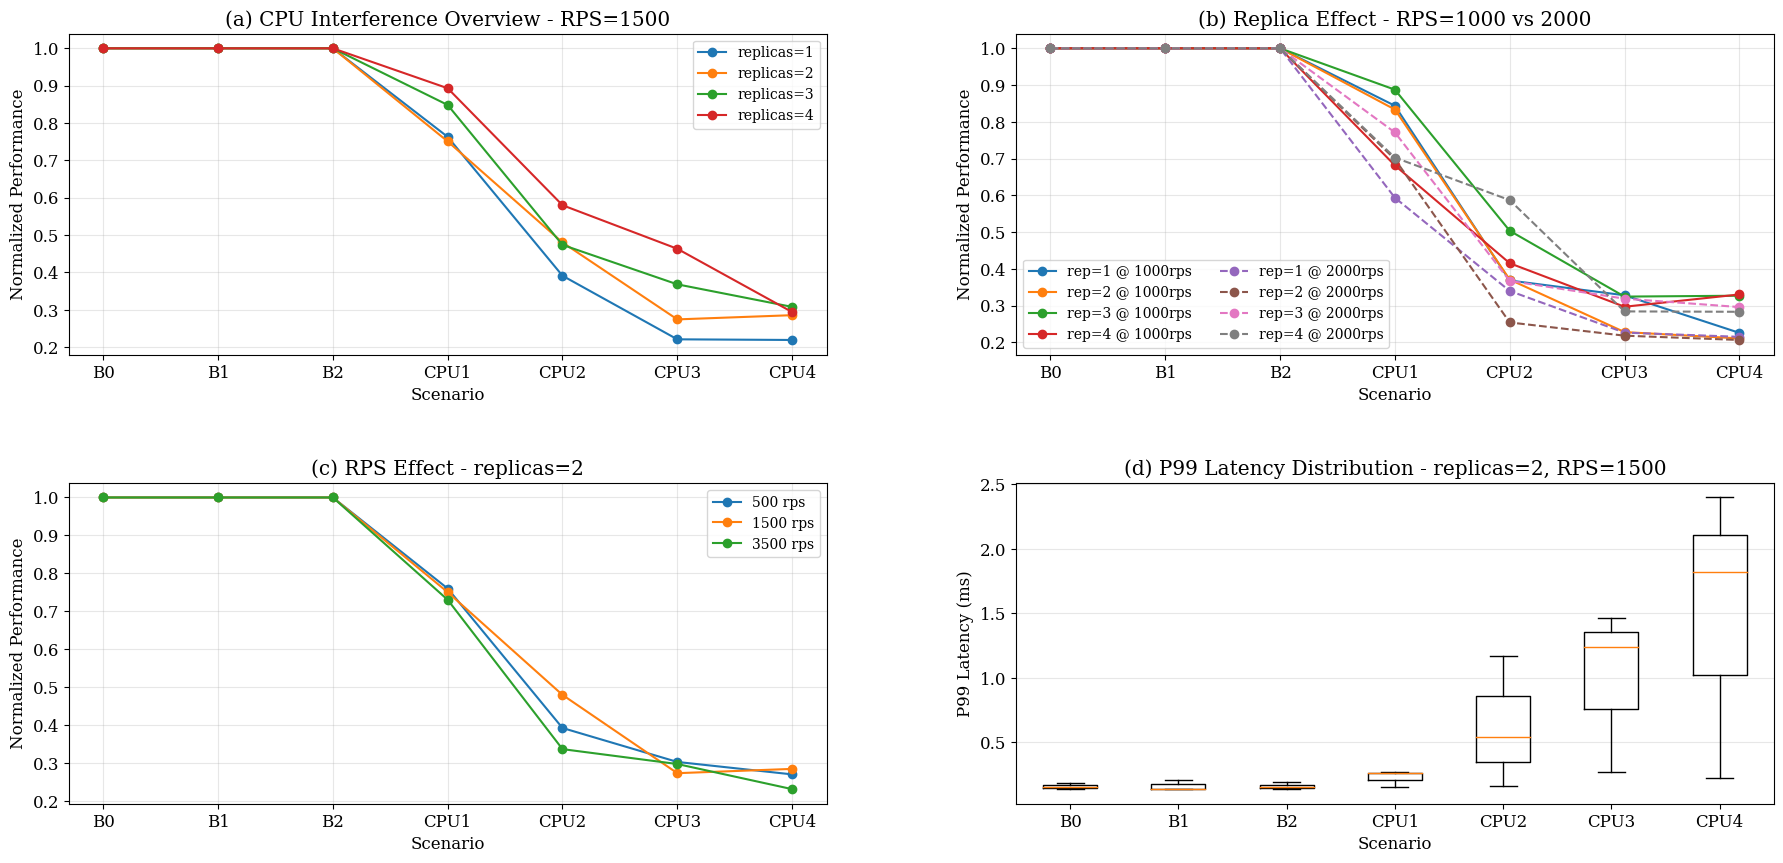

In [17]:
fig = plot_interference_effect(df_labeled, "CPU")
plt.show()  # if you want to display it interactively
# Save the figure in png format
fig.savefig("experiment_phaseA_CPU.png", dpi=300)

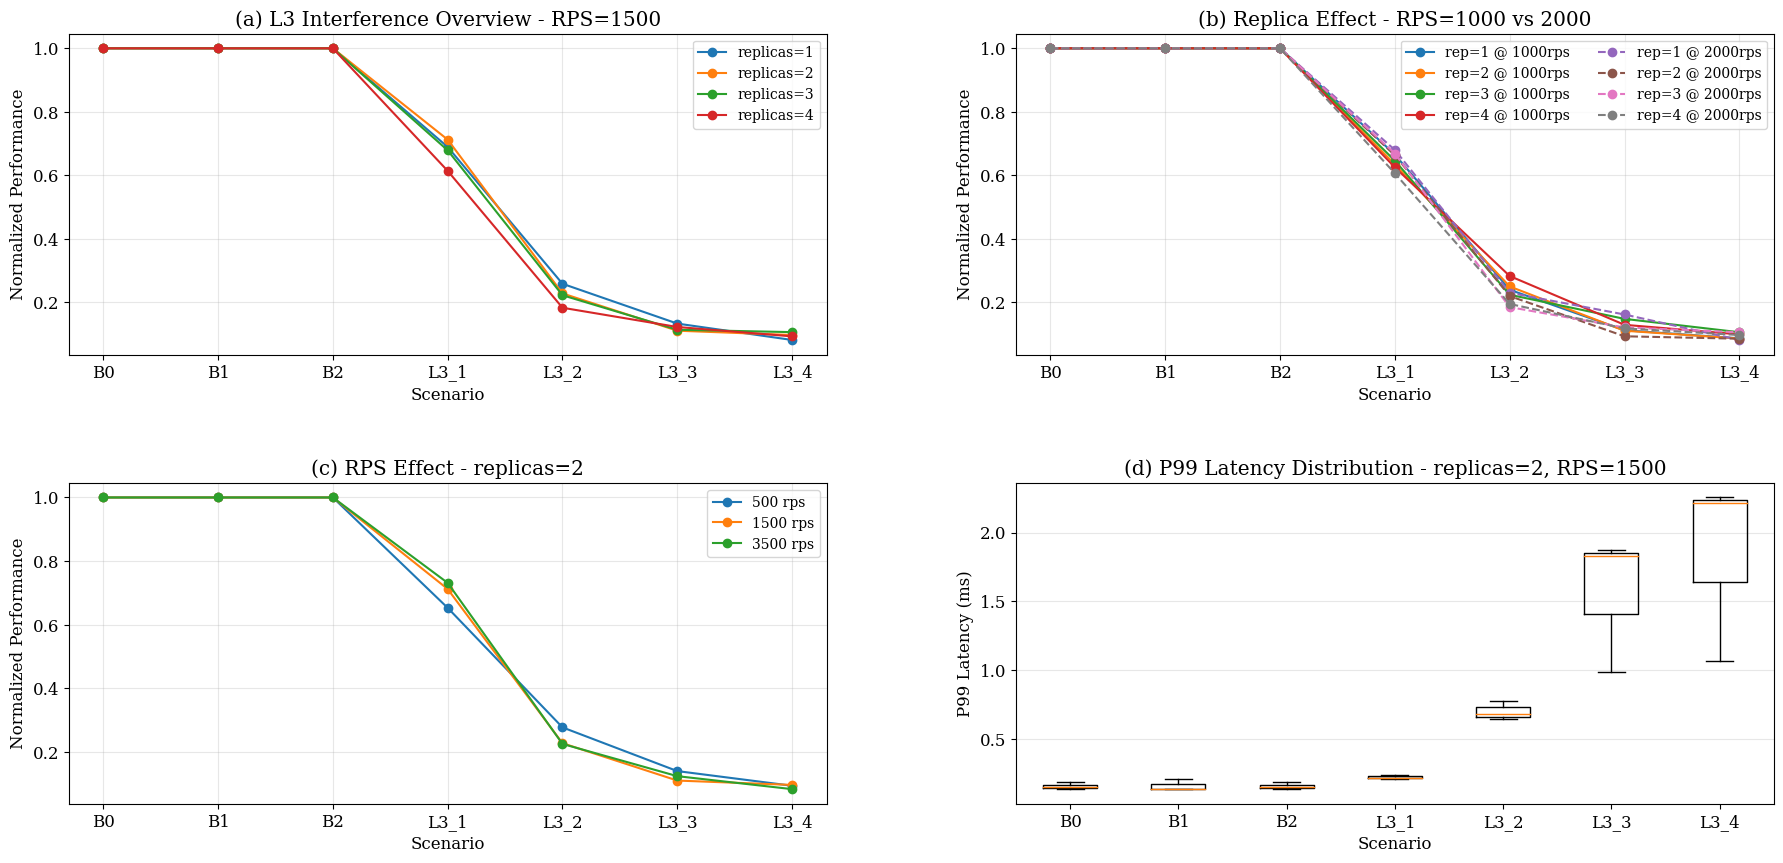

In [18]:
fig = plot_interference_effect(df_labeled, "L3")
plt.show()  # if you want to display it interactively
# Save the figure in png format
fig.savefig("experiment_phaseA_L3.png", dpi=300)

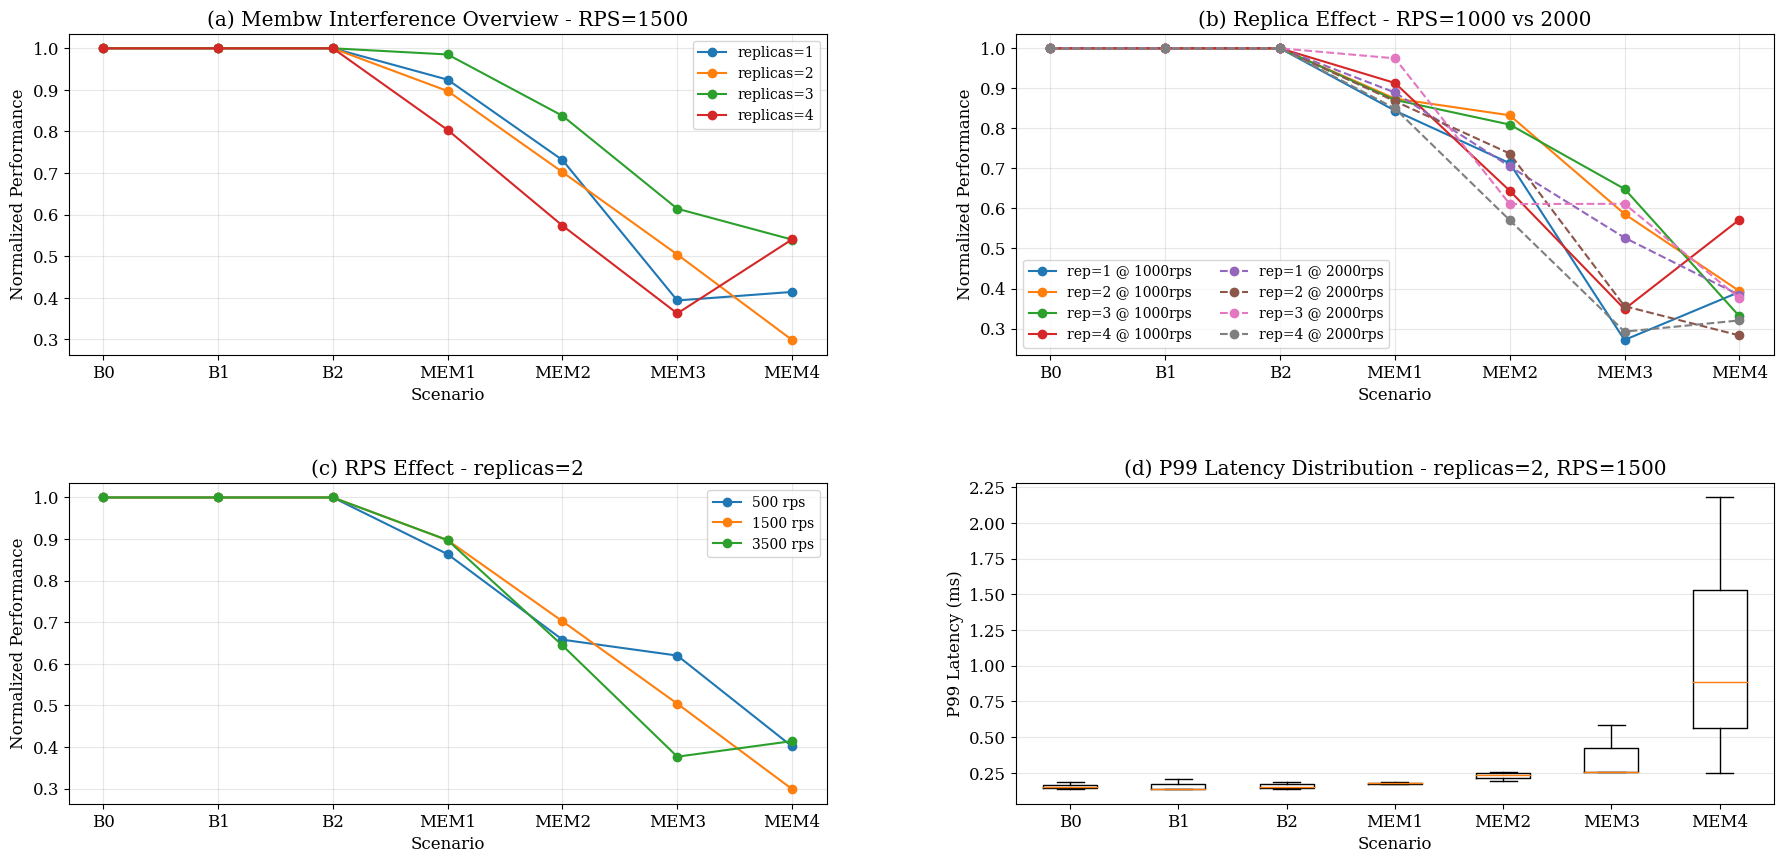

In [19]:
fig = plot_interference_effect(df_labeled, "Membw")
plt.show()  # if you want to display it interactively
# Save the figure in png format
fig.savefig("experiment_phaseA_MEMBW.png", dpi=300)

In [20]:
# Show the line of the df_labeled where Interference_Category is "MEMBW", Given_RPS is 3500 and Replicas is 2
df_labeled[(df_labeled['Interference_Category'] == 'Mix') & (df_labeled['Given_RPS'] == 3500) & (df_labeled['Replicas'] == 2)]

,UniqueID,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,FolderID,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf,Scenario_Label
977,2replicas_scenario51_3500rps_Memento_V02_3_Mix...,2replicas_scenario51_3500rps,2,1_CPU_1_L3,51,3500,Memento_V02_3_MixedScenarios,3500.003046,0.135,0.111,0.0,0.186,0.226,0.480,4.223,0.0,Mix,0.482870,MIX1
978,2replicas_scenario51_3500rps_TheGame_MIX_V01,2replicas_scenario51_3500rps,2,1_CPU_1_L3,51,3500,TheGame_MIX_V01,3500.021563,0.130,0.118,0.0,0.188,0.221,0.347,4.294,0.0,Mix,0.667947,MIX1
995,2replicas_scenario52_3500rps_Memento_V02_3_Mix...,2replicas_scenario52_3500rps,2,1_CPU_1_MemBW,52,3500,Memento_V02_3_MixedScenarios,3500.004794,0.113,0.091,0.0,0.148,0.174,0.469,4.322,0.0,Mix,0.494196,MIX2
996,2replicas_scenario52_3500rps_TheGame_MIX_V01,2replicas_scenario52_3500rps,2,1_CPU_1_MemBW,52,3500,TheGame_MIX_V01,3500.003518,0.153,0.123,0.0,0.259,0.303,0.452,4.712,0.0,Mix,0.512783,MIX2
1013,2replicas_scenario53_3500rps_Memento_V02_3_Mix...,2replicas_scenario53_3500rps,2,2_CPU_2_L3,53,3500,Memento_V02_3_MixedScenarios,3500.021305,0.328,0.190,0.0,0.705,0.971,2.042,8.519,0.0,Mix,0.113505,MIX3
1014,2replicas_scenario53_3500rps_TheGame_MIX_V01,2replicas_scenario53_3500rps,2,1_CPU_2_MemBW,53,3500,TheGame_MIX_V01,3500.003002,0.194,0.181,0.0,0.303,0.352,0.535,4.912,0.0,Mix,0.433229,MIX3
1031,2replicas_scenario54_3500rps_Memento_V02_3_Mix...,2replicas_scenario54_3500rps,2,1_CPU_1_L3_1_MemBW,54,3500,Memento_V02_3_MixedScenarios,3500.004572,0.149,0.118,0.0,0.202,0.252,0.704,6.663,0.0,Mix,0.329230,MIX4
1032,2replicas_scenario54_3500rps_TheGame_MIX_V01,2replicas_scenario54_3500rps,2,2_CPU_1_MemBW,54,3500,TheGame_MIX_V01,3500.003737,0.126,0.103,0.0,0.199,0.252,0.400,3.942,0.0,Mix,0.579444,MIX4
1049,2replicas_scenario55_3500rps_Memento_V02_3_Mix...,2replicas_scenario55_3500rps,2,3_CPU_1_L3,55,3500,Memento_V02_3_MixedScenarios,3500.004330,0.186,0.124,0.0,0.250,0.339,1.807,7.017,0.0,Mix,0.128267,MIX5
1050,2replicas_scenario55_3500rps_TheGame_MIX_V01,2replicas_scenario55_3500rps,2,1_CPU_2_L3,55,3500,TheGame_MIX_V01,3499.986130,0.246,0.175,0.0,0.496,0.640,0.949,10.883,0.0,Mix,0.244234,MIX5


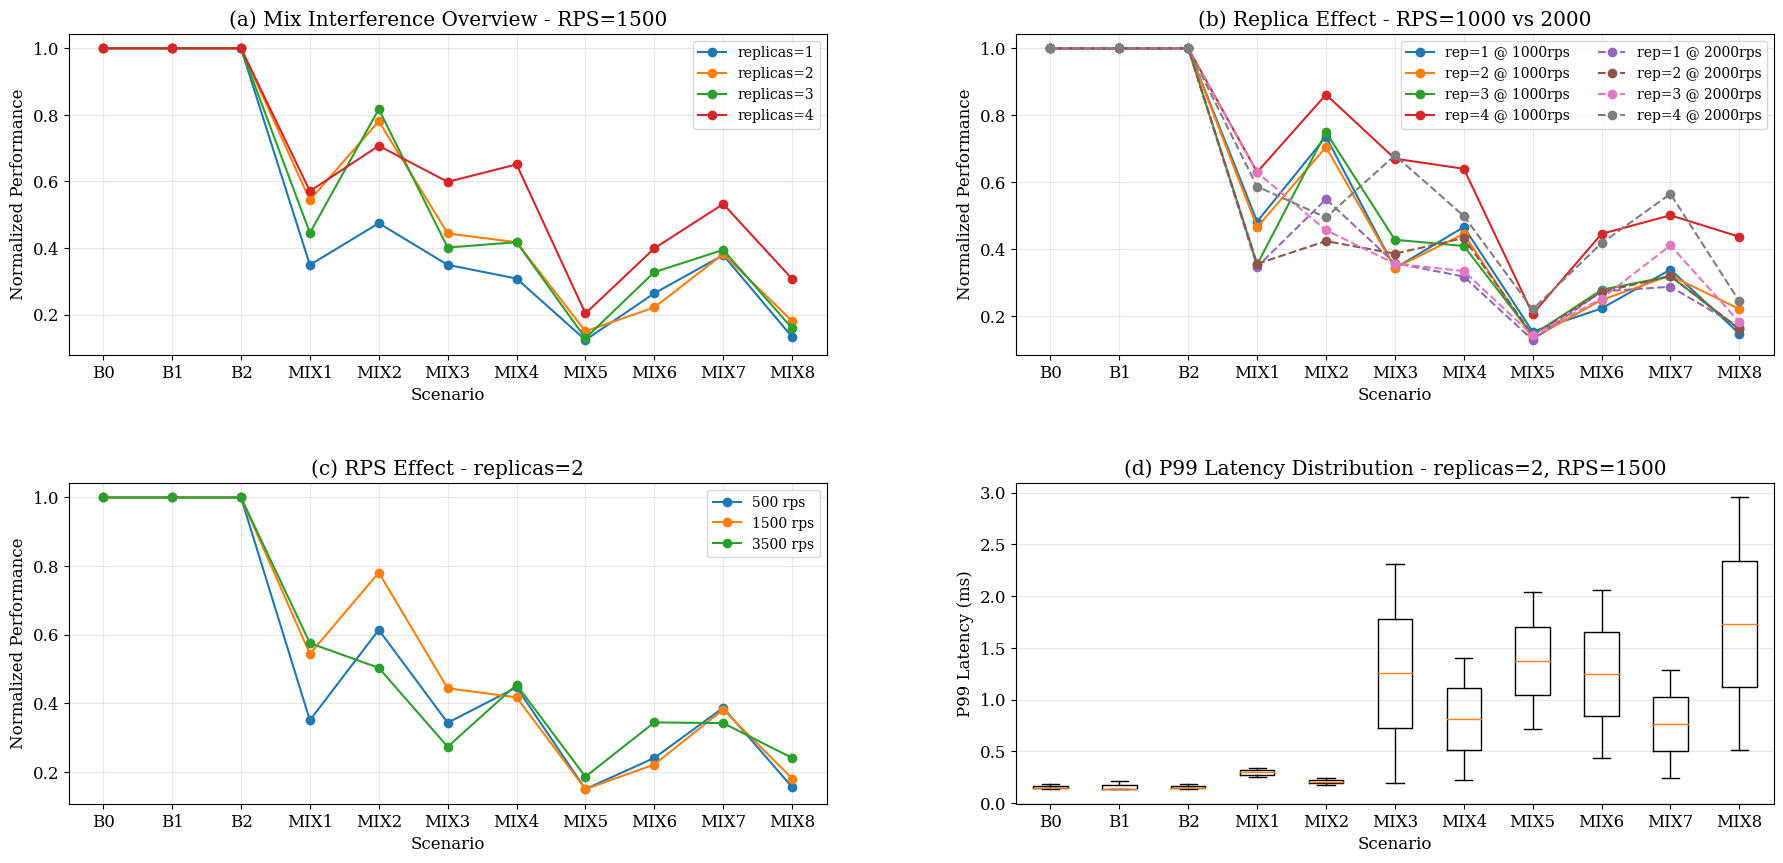

In [21]:
# For Mix Scenarios
fig = plot_interference_effect(df_labeled, "Mix")
plt.show()  # if you want to display it interactively
# Save the figure in png format
fig.savefig("experiment_phaseA_MIX.png", dpi=300)

##  3 Profiling: 

### **Given the state of the Server, what will the effect on the Application's Perfomance be?**

### 3.1. Application Profiling (Feature Extraction)

**Objective:** For each interference scenario, aggregate high-resolution PCM counters into a fixed set of summary features.  
- Compute the **mean** and **95th percentile** for each numeric counter (IPC, cache misses, memory bandwidth, C-state residencies, etc.).  
- Label each feature vector with its `Interference` scenario name so we can join later.

**Why calculate p95?**

When summarizing high-resolution counter streams into fixed features, the **mean** captures average behavior but can miss intermittent yet impactful bursts. Computing the **95th percentile** for each metric (e.g., IPC, cache misses, memory bandwidth) lets us quantify those sustained high-interference windows without over-reacting to single outliers.  
- **Captures “Spikiness”**: If a resource experiences occasional but prolonged contention, the 95th percentile rises, signaling potential tail-latency issues.  
- **Predicts Tail Latency**: Rare but sustained high counter values often drive P99 latency spikes. Including a high-percentile feature gives our model the ability to link resource “bursts” to service-level objective (SLO) violations.  
- **Robustness**: Unlike the maximum, the 95th percentile is less sensitive to one-off anomalies, yet still focuses on the worst 5% of the sampling windows—precisely the behavior most correlated with tail performance degradation.



In [22]:
def compute_windowed_stats(series, window_size, stats):
    """Compute rolling-window-based stats for a Series."""
    results = {}
    if window_size:
        win = series.rolling(window=window_size, center=True, min_periods=1)
        if 'mean' in stats: results['mean'] = win.mean().mean()
        if 'std' in stats: results['std'] = win.std().mean()
        if 'max' in stats: results['max'] = win.max().mean()
        if 'min' in stats: results['min'] = win.min().mean()
        if 'p95' in stats: results['p95'] = win.quantile(0.95).mean()
    else:
        if 'mean' in stats: results['mean'] = series.mean()
        if 'std' in stats: results['std'] = series.std()
        if 'max' in stats: results['max'] = series.max()
        if 'min' in stats: results['min'] = series.min()
        if 'p95' in stats: results['p95'] = series.quantile(0.95)
    return results


import pandas as pd
from typing import Dict, List

def compute_core_features_from_df(
    df_pcm: pd.DataFrame,
    target_cores: List[int] = [3, 4, 5],
    window_size: int = 2,
    stats: List[str] = ['mean', 'p95', 'std'],
    core_prefix_template: str = "Core{core} (Socket 0) - "
) -> Dict[str, float]:
    """
    Computes per-core and AvgCore PCM stats from a single PCM DataFrame.

    Parameters:
    - df_pcm: DataFrame with time-series PCM metrics
    - target_cores: cores to analyze (default [3,4,5])
    - window_size: window for rolling stat calculation
    - stats: stats to compute (e.g., ['mean','std','p95'])
    - core_prefix_template: pattern for column prefix

    Returns:
    - Dict of {feature_name: value}
    """
    from collections import defaultdict

    features = {}
    core_metrics_group = defaultdict(list)

    # Metrics we care about
    keep_metrics = ['IPC', 'L3MISS', 'L2MISS', 'C0res%', 'C1res%', 'C6res%', 'PhysIPC']
    #keep_metrics = ['IPC', 'L3MISS', 'L2MISS', 'C0res%', 'C1res%', 'C6res%']


    for core in target_cores:
        core_prefix = core_prefix_template.format(core=core)
        core_cols = [col for col in df_pcm.columns if col.startswith(core_prefix)]
        core_cols = [col for col in core_cols if any(m in col for m in keep_metrics)]

        for col in core_cols:
            metric = col.replace(core_prefix, '').replace('%', '')
            clean_name = f'Core{core}_{metric}'
            series = df_pcm[col]

            stat_values = compute_windowed_stats(series, window_size, stats)
            for stat, value in stat_values.items():
                features[f'{stat}_{clean_name}'] = value

            core_metrics_group[metric].append(series)

    # Compute aggregated AvgCore metrics
    for metric, series_list in core_metrics_group.items():
        #continue
        if series_list:
            df_metric = pd.concat(series_list, axis=1)
            agg_series = df_metric.mean(axis=1)  # row-wise average
            agg_stats = compute_windowed_stats(agg_series, window_size, stats)
            for stat, value in agg_stats.items():
                features[f'{stat}_AvgCore_{metric}'] = value

    return features


In [23]:
import os
import glob
import pandas as pd

def extract_pcm(data_dir: str,target_cores: list = [3, 4, 5],window_size: int = 2,stats: tuple = ('mean', 'p95', 'std'),core_prefix_template: str = 'Core{core} (Socket 0) - ') -> pd.DataFrame:
    """
    Processes a single directory containing pcm_core CSVs.
    Returns a one-row DataFrame of extracted features.
    """
    # Find core CSV files
    core_pattern = os.path.join(data_dir, 'pcm_core_*.csv')
    core_files = glob.glob(core_pattern)

    if not core_files:
        print(f"⚠️ No PCM core files found in {data_dir}")
        return pd.DataFrame()

    # Load and process each core file (usually 1 per folder)
    all_features = []
    for path in core_files:
        df_pcm = pd.read_csv(path)
        # If path has TheGame then make window_size 8
        if 'TheGame' in data_dir:
            window_size = 8
        feature_dict = compute_core_features_from_df(
            df_pcm,
            target_cores=target_cores,
            window_size=window_size,
            stats=stats,
            core_prefix_template=core_prefix_template
        )

        # Add scenario info (e.g., from filename)
        pcm_id = os.path.basename(path).replace('pcm_core_', '').replace('.csv', '')
        feature_dict['Test_ID'] = pcm_id
        # Optionally extract replicas and RPS
        import re
        match_rps = re.search(r'(\d+)rps', pcm_id)
        match_rep = re.search(r'(\d+)replicas', pcm_id)
        if match_rps:
            feature_dict['RPS'] = int(match_rps.group(1))
        if match_rep:
            feature_dict['Replicas'] = int(match_rep.group(1))

        all_features.append(feature_dict)

    df_result = pd.DataFrame(all_features)
    if not df_result.empty:
        folder_name = os.path.basename(data_dir)
        df_result["FolderID"] = folder_name
        df_result["UniqueID"] = df_result["Test_ID"].astype(str) + "_" + folder_name

    return df_result


In [24]:
def extract_from_multiple_dirs(dirs: list,**kwargs) -> pd.DataFrame:
    """
    Runs extract_pcm() for each directory in `dirs` and concatenates the results.
    kwargs are passed to extract_pcm().
    """
    all_dfs = []
    for d in dirs:
        df = extract_pcm(d, **kwargs)
        if not df.empty:
            all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()


In [25]:
Target_Cores = [3, 4, 5]
stats = ('mean', 'p95', 'std')

df_features = extract_from_multiple_dirs(folders,target_cores=Target_Cores,window_size=4,stats=stats)

In [26]:
display(df_features)

,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,mean_Core3_C0res,...,std_AvgCore_C6res,p95_AvgCore_C6res,mean_AvgCore_PhysIPC,std_AvgCore_PhysIPC,p95_AvgCore_PhysIPC,Test_ID,RPS,Replicas,FolderID,UniqueID
0,0.835946,0.198771,1.056311,0.012883,0.004419,0.017568,0.548806,0.038918,0.578365,1.911419,...,0.0,0.0,27.338483,1.956678,29.313995,1replicas_scenario31_3000rps,3000,1,Memento_V01,1replicas_scenario31_3000rps_Memento_V01
1,0.689797,0.018638,0.708459,0.009730,0.000541,0.010000,0.324257,0.020563,0.341959,1.027725,...,0.0,0.0,17.485345,0.685515,18.184394,1replicas_scenario0_1500rps,1500,1,Memento_V01,1replicas_scenario0_1500rps_Memento_V01
2,1.676396,0.155112,1.816622,0.010000,0.000000,0.010000,0.041644,0.003150,0.045338,1.521261,...,0.0,0.0,31.209182,2.338577,33.890514,1replicas_scenario32_100rps,100,1,Memento_V01,1replicas_scenario32_100rps_Memento_V01
3,1.154032,0.724466,1.955622,0.021464,0.003431,0.024689,0.317680,0.019616,0.333216,1.305991,...,0.0,0.0,45.127080,6.090294,51.137741,1replicas_scenario21_3500rps,3500,1,Memento_V01,1replicas_scenario21_3500rps_Memento_V01
4,0.699955,0.030055,0.731378,0.010000,0.000000,0.010000,0.442207,0.019989,0.458514,1.368423,...,0.0,0.0,18.077579,0.638474,18.746784,1replicas_scenario1_2500rps,2500,1,Memento_V01,1replicas_scenario1_2500rps_Memento_V01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1893,0.555315,0.027009,0.583068,0.092748,0.006117,0.098122,0.919730,0.053231,0.962514,3.503559,...,0.0,0.0,11.906851,0.629392,12.607178,1replicas_scenario64_3000rps,3000,1,Green_Book_V01,1replicas_scenario64_3000rps_Green_Book_V01
1894,0.684459,0.022505,0.707351,0.060135,0.007564,0.067905,2.421937,0.156119,2.544459,7.933468,...,0.0,0.0,16.175135,0.495611,16.714288,2replicas_scenario62_3500rps,3500,2,Green_Book_V01,2replicas_scenario62_3500rps_Green_Book_V01
1895,0.473041,0.021548,0.496108,0.308581,0.024845,0.330284,2.062455,0.141091,2.179595,7.641937,...,0.0,0.0,9.585638,0.383827,9.985198,2replicas_scenario63_2500rps,2500,2,Green_Book_V01,2replicas_scenario63_2500rps_Green_Book_V01
1896,0.379077,0.024090,0.406054,0.585450,0.033823,0.612095,2.907703,0.153695,3.020541,14.635923,...,0.0,0.0,6.998153,0.281718,7.307072,2replicas_scenario61_4000rps,4000,2,Green_Book_V01,2replicas_scenario61_4000rps_Green_Book_V01


### 3.2. Label Joining & Normalized Performance

**Objective:**  
Merge each hardware‐counter feature vector (`df_features`) with its corresponding observed tail‐latency, then convert raw latencies into a _normalized slowdown ratio_ that becomes our RiskScore target (`norm_perf`).

**Steps:**

1. **Extract per-traffic baseline latency and Compute slowdown ratio**  
    - For each `Interference` scenario, extract the baseline latency (e.g. P99) from the row where `Interference = "baseline"`.  
    - Compute the slowdown ratio:  
      ```python
      df_perf['Normalized_Performance'] = df_perf['P99_Latency'] / df_perf['Baseline_P99_Latency']
      ```
    - This gives us a measure of how much worse the latency is under interference compared to the baseline.

3. **Merge with features and set RiskScore**  
   - Inner‐join your feature table on the `Interference` column
   - The resulting `df_ml` contains one row per experiment, with:
     - all hardware‐counter summaries
     - the normalized target `norm_perf` (Risk < 1 ⇒ likely SLO violation)

**Why use norm_perf column?**  
- **Workload-agnostic target:** by normalizing against each test’s own baseline, the model doesn’t need to learn absolute latencies for every traffic pattern—only how much interference slows it down.  
- **Aligned with SLOs:** `norm_perf` becomes a direct proxy for “fraction of SLO consumed” (e.g. predicted P99 / SLO_ms), so a learned model can output a true RiskScore that the scheduler uses to decide placement or mitigation.


In [27]:
display(df_perf)
print(df_perf.columns)

,UniqueID,Test_ID,Replicas,Interference_Name,Interference_ID,Given_RPS,FolderID,Throughput,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf
0,1replicas_scenario0_1000rps_Fight_Club_V01,1replicas_scenario0_1000rps,1,Baseline0,0,1000,Fight_Club_V01,1000.004331,0.087,0.084,0.0,0.100,0.108,0.141,2.682,0.0,Baseline,1.000000
1,1replicas_scenario0_1000rps_Memento_V01,1replicas_scenario0_1000rps,1,Baseline0,0,1000,Memento_V01,1000.002275,0.087,0.084,0.0,0.100,0.108,0.150,3.678,0.0,Baseline,1.000000
2,1replicas_scenario0_1000rps_TheGame_V01,1replicas_scenario0_1000rps,1,Baseline0,0,1000,TheGame_V01,1000.003594,0.088,0.085,0.0,0.102,0.111,0.146,3.211,0.0,Baseline,1.000000
3,1replicas_scenario0_100rps_Memento_V01,1replicas_scenario0_100rps,1,Baseline0,0,100,Memento_V01,100.004986,0.301,0.312,0.0,0.480,0.541,0.598,1.005,0.0,Baseline,1.000000
4,1replicas_scenario0_100rps_TheGame_V01,1replicas_scenario0_100rps,1,Baseline0,0,100,TheGame_V01,100.005097,0.295,0.310,0.0,0.442,0.539,0.606,2.918,0.0,Baseline,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,4replicas_scenario58_2500rps_TheGame_MIX_V02,4replicas_scenario58_2500rps,4,1_L3_3_MemBW,58,2500,TheGame_MIX_V02,2500.004305,0.217,0.165,0.0,0.413,0.522,0.723,5.128,0.0,Mix,0.261872
1905,4replicas_scenario58_3000rps_TheGame_MIX_V02,4replicas_scenario58_3000rps,4,1_L3_3_MemBW,58,3000,TheGame_MIX_V02,3000.000833,0.278,0.247,0.0,0.430,0.506,0.776,10.012,0.0,Mix,0.262887
1906,4replicas_scenario58_3500rps_TheGame_MIX_V02,4replicas_scenario58_3500rps,4,1_L3_3_MemBW,58,3500,TheGame_MIX_V02,3500.001452,0.201,0.162,0.0,0.356,0.427,0.635,7.087,0.0,Mix,0.381890
1907,4replicas_scenario58_4000rps_TheGame_MIX_V02,4replicas_scenario58_4000rps,4,1_L3_3_MemBW,58,4000,TheGame_MIX_V02,4000.018785,0.232,0.190,0.0,0.388,0.486,0.877,11.036,0.0,Mix,0.333903


Index(['UniqueID', 'Test_ID', 'Replicas', 'Interference_Name',
       'Interference_ID', 'Given_RPS', 'FolderID', 'Throughput', 'Avg_Latency',
       'P50_Latency', 'P75_Latency', 'P90_Latency', 'P95_Latency',
       'P99_Latency', 'Max_Latency', 'Errors', 'Interference_Category',
       'norm_perf'],
      dtype='object')


In [28]:
def merge_features_with_performance(df_features, df_perf):
    """
    Merge PCM features with latency performance metrics on 'Test_ID'.
    
    Parameters:
    - df_features: DataFrame from PCM feature extraction
    - df_perf: DataFrame with latency metrics and norm_perf
    
    Returns:
    - Merged DataFrame ready for model training
    """
    merged_df = pd.merge(df_features, df_perf, on='UniqueID', how='inner')
    
    print(f"✅ Merged shape: {merged_df.shape}")
    print(f"🔍 Columns: {merged_df.columns.tolist()[:10]}... + {len(merged_df.columns)-10} more")
    
    return merged_df

In [29]:
df_ml = merge_features_with_performance(df_features, df_perf)
display(df_ml)

✅ Merged shape: (1898, 106)
🔍 Columns: ['mean_Core3_IPC', 'std_Core3_IPC', 'p95_Core3_IPC', 'mean_Core3_L3MISS', 'std_Core3_L3MISS', 'p95_Core3_L3MISS', 'mean_Core3_L2MISS', 'std_Core3_L2MISS', 'p95_Core3_L2MISS', 'mean_Core3_C0res']... + 96 more


,mean_Core3_IPC,std_Core3_IPC,p95_Core3_IPC,mean_Core3_L3MISS,std_Core3_L3MISS,p95_Core3_L3MISS,mean_Core3_L2MISS,std_Core3_L2MISS,p95_Core3_L2MISS,mean_Core3_C0res,...,Avg_Latency,P50_Latency,P75_Latency,P90_Latency,P95_Latency,P99_Latency,Max_Latency,Errors,Interference_Category,norm_perf
0,0.835946,0.198771,1.056311,0.012883,0.004419,0.017568,0.548806,0.038918,0.578365,1.911419,...,0.099,0.091,0.0,0.132,0.150,0.217,4.026,0.0,Membw,0.904250
1,0.689797,0.018638,0.708459,0.009730,0.000541,0.010000,0.324257,0.020563,0.341959,1.027725,...,0.086,0.083,0.0,0.103,0.110,0.136,3.099,0.0,Baseline,1.000000
2,1.676396,0.155112,1.816622,0.010000,0.000000,0.010000,0.041644,0.003150,0.045338,1.521261,...,0.306,0.296,0.0,0.444,0.523,0.613,2.324,0.0,Membw,0.981512
3,1.154032,0.724466,1.955622,0.021464,0.003431,0.024689,0.317680,0.019616,0.333216,1.305991,...,0.119,0.109,0.0,0.170,0.196,0.282,3.680,0.0,L3,0.724192
4,0.699955,0.030055,0.731378,0.010000,0.000000,0.010000,0.442207,0.019989,0.458514,1.368423,...,0.090,0.087,0.0,0.113,0.126,0.158,3.704,0.0,Baseline,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1893,0.555315,0.027009,0.583068,0.092748,0.006117,0.098122,0.919730,0.053231,0.962514,3.503559,...,0.171,0.135,0.0,0.293,0.359,0.545,5.750,0.0,Other,0.360041
1894,0.684459,0.022505,0.707351,0.060135,0.007564,0.067905,2.421937,0.156119,2.544459,7.933468,...,0.139,0.120,0.0,0.215,0.255,0.381,4.079,0.0,Other,0.608341
1895,0.473041,0.021548,0.496108,0.308581,0.024845,0.330284,2.062455,0.141091,2.179595,7.641937,...,0.194,0.136,0.0,0.371,0.504,0.754,4.321,0.0,Other,0.222370
1896,0.379077,0.024090,0.406054,0.585450,0.033823,0.612095,2.907703,0.153695,3.020541,14.635923,...,0.358,0.280,0.0,0.660,0.806,1.388,18.203,0.0,Other,0.182037


In [30]:
# Sanity check
missing_ids = set(df_perf["UniqueID"]) - set(df_features["UniqueID"])
if missing_ids:
    print(f"⚠️ Missing UniqueIDs in features: {missing_ids}")


⚠️ Missing UniqueIDs in features: {'1replicas_scenario2_4000rps_TheGame_V01', '2replicas_scenario12_4000rps_TheGame_V02_2', '3replicas_scenario56_4000rps_TheGame_MIX_V02', '2replicas_scenario11_3500rps_TheGame_V02_2', '2replicas_scenario34_3000rps_TheGame_V02_2', '3replicas_scenario55_3500rps_TheGame_MIX_V02', '1replicas_scenario21_2500rps_TheGame_V01', '2replicas_scenario22_2500rps_TheGame_V02_2', '1replicas_scenario58_3500rps_TheGame_MIX_V01', '3replicas_scenario55_4000rps_TheGame_MIX_V02', '1replicas_scenario2_3500rps_TheGame_V01'}


### 3.3. Preprocessing & Pipeline Construction

---

#### 1. Feature Selection  
- All stats have been calculated:
  - `mean_`, `std_`, `p95_` for each counter.
- Now we have to choose which features to include in the model. 
- These features should also be used in the predictor-api 

#### 2. The Pipeline & Its Steps  
- **StandardScaler**: Normalize each feature to zero mean and unit variance.
- **PolynomialFeatures**: Expand the feature set with polynomial combinations of the original features.
- **PCA**: Reduce dimensionality while preserving variance.
- **RandomForestRegressor**: Train a regression model to predict the slowdown ratio.


In [31]:
import json

# --- Load the selected feature names from JSON ---
with open("selected_features.json", "r") as f:
    selected_features = json.load(f)

# Safety: ensure it's a list of strings
selected_features = [str(x) for x in selected_features]

# --- Build feature list from df_ml columns ---
base_extra = []
if "RPS" in df_ml.columns:
    base_extra.append("RPS")
# Prefer 'Replicas_x' if present, else fall back to 'Replicas'
if "Replicas_x" in df_ml.columns:
    base_extra.append("Replicas_x")
elif "Replicas" in df_ml.columns:
    base_extra.append("Replicas")

# Keep only features that exist in df_ml (preserve JSON order)
present = [c for c in selected_features if c in df_ml.columns]
missing = [c for c in selected_features if c not in df_ml.columns]

# Build final feature list (extras first is fine; adjust order if you prefer)
feature_cols = base_extra + present

# Diagnostics
print(f"Extra (non-PCM) features used: {base_extra}")
if missing:
    print(f"WARNING: {len(missing)} selected features not found in df_ml. Examples: {missing[:10]}")

# --- Create X, y ---
X = df_ml[feature_cols].copy()
y = df_ml["norm_perf"].copy()

print(X.shape, y.shape)
print(f"Features: {len(X.columns)} | Samples: {len(X)}")
print("Feature names:", X.columns.tolist())




# 2. Define the 3 pipelines
pipelines = {
    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Ridge Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('reg', Ridge(alpha=1.0))
    ]),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# First XGBoost used to rank feature importances
#feature_selector = SelectFromModel(
#    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
#    max_features=40,
#    threshold=-float('inf')  # Don't use threshold, just keep top N
#)

#pipelines["XGBoost_Top40Feats"] = Pipeline([
#    ('selector', feature_selector),
#    ('reg', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
#])


Extra (non-PCM) features used: ['RPS', 'Replicas_x']
(1898, 25) (1898,)
Features: 25 | Samples: 1898
Feature names: ['RPS', 'Replicas_x', 'mean_Core3_IPC', 'std_Core3_IPC', 'p95_Core3_IPC', 'mean_Core3_L3MISS', 'std_Core3_L3MISS', 'mean_Core3_L2MISS', 'std_Core3_L2MISS', 'mean_Core3_C0res', 'std_Core3_C0res', 'mean_Core3_C1res', 'std_Core3_C1res', 'mean_Core4_IPC', 'std_Core4_IPC', 'p95_Core4_IPC', 'std_Core4_L3MISS', 'std_Core4_L2MISS', 'std_Core4_C0res', 'mean_Core4_C1res', 'std_Core4_C1res', 'mean_Core5_IPC', 'std_Core5_IPC', 'std_Core5_C0res', 'std_Core5_C1res']


In [32]:
"""
# 1. Define input features
#stat_prefixes = ('mean_', 'p95_', 'std_')                      # ALL
#stat_prefixes = ('mean_', 'p95_')                               # Only mean and p95
#stat_prefixes = ('mean_AvgCore_', 'p95_AvgCore_')              # Only Averages 'std_AvgCore_' too
stat_prefixes = ('mean_Core', 'p95_Core', 'std_Core')          # All stats for cores (not the AvgCore ones)

from sklearn.feature_selection import SelectFromModel

# Features should be, RPS and Replicas and also the ones fit to the selected_features.json file 
feature_cols = [col for col in df_ml.columns if col.startswith(stat_prefixes) or col in ('RPS', 'Replicas_x')]
X = df_ml[feature_cols]
y = df_ml['norm_perf']

print(X.shape, y.shape)
print(f"Features: {len(X.columns)} | Samples: {len(X)}")
# Print names of the features
print("Feature names:", X.columns.tolist())


"""

'\n# 1. Define input features\n#stat_prefixes = (\'mean_\', \'p95_\', \'std_\')                      # ALL\n#stat_prefixes = (\'mean_\', \'p95_\')                               # Only mean and p95\n#stat_prefixes = (\'mean_AvgCore_\', \'p95_AvgCore_\')              # Only Averages \'std_AvgCore_\' too\nstat_prefixes = (\'mean_Core\', \'p95_Core\', \'std_Core\')          # All stats for cores (not the AvgCore ones)\n\nfrom sklearn.feature_selection import SelectFromModel\n\n# Features should be, RPS and Replicas and also the ones fit to the selected_features.json file \nfeature_cols = [col for col in df_ml.columns if col.startswith(stat_prefixes) or col in (\'RPS\', \'Replicas_x\')]\nX = df_ml[feature_cols]\ny = df_ml[\'norm_perf\']\n\nprint(X.shape, y.shape)\nprint(f"Features: {len(X.columns)} | Samples: {len(X)}")\n# Print names of the features\nprint("Feature names:", X.columns.tolist())\n\n\n'

In [32]:
# Store the "Feature names:", X.columns.tolist() to a list in a file in the parent folder of this notebook
feature_names = X.columns.tolist()
feature_names_file = Path("../predictor_api/feature_names.json")
# Save feature names to a JSON file
with open(feature_names_file, 'w') as f:
    json.dump(feature_names, f)

### 3.4 Model Training & Evaluation

**Objective:**  
Assess how well our pipeline predicts the normalized slowdown (`norm_perf`) on interference scenarios it hasn’t seen, and quantify the expected error.

1. **Cross-Validation Strategy**  
   - We use **Leave-One-Interference-Level-Out** (LeaveOneGroupOut) CV, grouping by the `Interference` label.  
   - Each fold trains on all but one interference intensity (e.g. CPU×2, MemBW×4, etc.) and tests on the held-out level—mimicking how we need to generalize to new contention patterns.

2. **Scoring Metrics**  
   - **Mean Squared Error (MSE):** penalizes large deviations heavily; tells us how far off our predicted slowdown is, on average, in squared units.  
   - **Mean Absolute Error (MAE):** more interpretable “on average we’re ±X% off” in the slowdown ratio.

3. **Interpreting Results**  
   - A low MAE (e.g. 0.05) means we predict that a node’s tail latency will be within 5% of its true slowdown.  
   - These errors guide confidence in scheduling decisions: if the predicted slowdown differences between two nodes exceed our MAE, we can reliably pick the best node.

4. **Scheduler Integration**  
   - At runtime, the scheduler will load this **trained pipeline**, sample live hardware counters on each node, and compute `predicted_norm_perf`.  
   - It then assigns new pods to the node with the lowest predicted slowdown, or triggers mitigation if all nodes exceed an acceptable threshold.

By successfully completing this subsection, we’ll have a validated, quantifiable predictor of interference-induced slowdowns—our RiskScore—that the scheduler can trust for placement decisions.  


In [ ]:
# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Evaluate each pipeline
results = []

for name, model in pipelines.items():
    print(f"\n🔍 Evaluating: {name}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # PCA explained variance (only available in the RF pipeline)
    if name == "Random Forest":
        explained_var = model.named_steps['pca'].explained_variance_ratio_.sum()
    else:
        explained_var = None

    # Cross-validated MAE
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    
    print(f"✅ MAE: {mae:.4f}")
    print(f"📈 R²: {r2:.4f}")
    print(f"📉 Cross-validated MAE: {cv_mae:.4f}")
    if explained_var is not None:
        print(f"📊 PCA retained variance: {explained_var:.1%}")
    
    results.append({
        "Model": name,
        "MAE": mae,
        "R²": r2,
        "CV_MAE": cv_mae,
        "PCA_Variance": explained_var
    })

# 5. Show comparison table
df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("\n🏁 Model Comparison:")
display(df_results)


🔍 Evaluating: Random Forest
✅ MAE: 0.1220
📈 R²: 0.7727
📉 Cross-validated MAE: 0.1699
📊 PCA retained variance: 95.1%

🔍 Evaluating: Ridge Regression
✅ MAE: 0.1806
📈 R²: 0.1732
📉 Cross-validated MAE: 0.7778

🔍 Evaluating: XGBoost
✅ MAE: 0.0742
📈 R²: 0.9012
📉 Cross-validated MAE: 0.1171

🏁 Model Comparison:


,Model,MAE,R²,CV_MAE,PCA_Variance
2,XGBoost,0.074238,0.901239,0.117101,NaN
0,Random Forest,0.121985,0.772691,0.169895,0.950955
1,Ridge Regression,0.180625,0.173170,0.777821,NaN


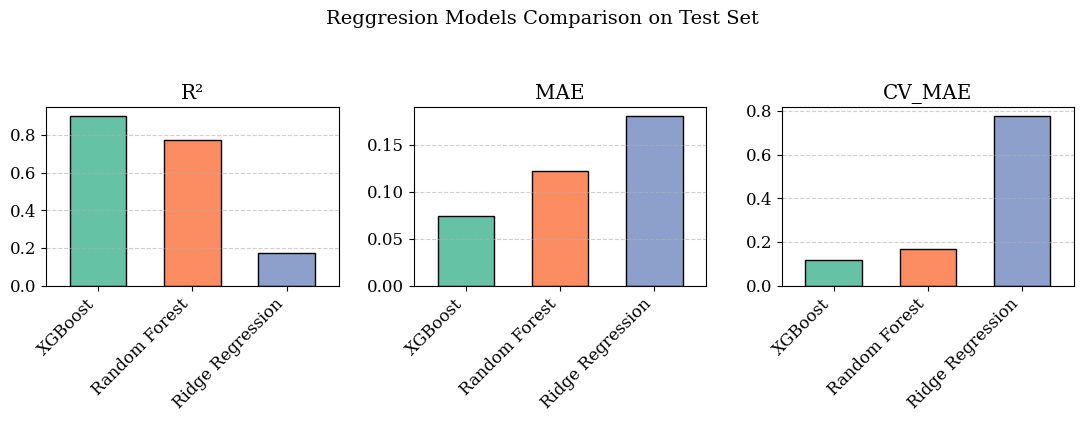

In [68]:
import matplotlib.pyplot as plt

metrics_to_plot = ["R²", "MAE", "CV_MAE"]
colors = plt.cm.Set2.colors  # nice qualitative palette
plt.rcParams['font.family'] = 'DejaVu Serif'
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(11, 4))  # narrower width

for ax, metric in zip(axes, metrics_to_plot):
    df_results.plot(
        kind="bar", x="Model", y=metric, ax=ax, legend=False,
        color=colors, edgecolor="black", width=0.6
    )
    ax.set_title(metric)
    ax.set_xlabel("")
    ax.set_ylabel("")  # no ylabel
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Reggresion Models Comparison on Test Set", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


## 4. Exporting the Predictor

In [33]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [34]:
# The best model based on the previous evaluations, is the Random Forest with PCA
# Get the trained model from the pipelines
best_model = pipelines["XGBoost"]

In [35]:
import joblib   
import os
import pickle

# Define save path
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

# Save full pipeline
# Save model
with open("models/slowdown_predictor.pkl", "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Trained model pipeline saved to /model")


✅ Trained model pipeline saved to /model
